<a href="https://colab.research.google.com/github/mdaugherity/MachineLearning2026/blob/main/tutorial/Tutorial_08_Cross_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dr. Daugherity, ACU PHYS 453**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Tutorial 7 - Cross Validation with GridCV

Now we make this approach more official and see how to properly tune and evaluate classifiers.  Remember, the goal is to finish the overview of classification problems before we dive in to seeing how more classifiers actually work.



We will do this twice:
* Data used for tuning the best parameters is usually called **VALIDATION DATA**.  We will use a cool trick called cross-validation to use all of the data efficiently.
* After all of the choices are made and everything is done, only then will we use the **TEST DATA** to estimate the final performance of the classifier on new data.

**References**
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
* https://scikit-learn.org/stable/modules/cross_validation.html  (figure source)
* https://scikit-learn.org/stable/common_pitfalls.html#data-leakage

**Problem Statement: Tuning Hyperparameters**

Essentially all classifiers have parameters you can tune to improve performance.  For example, how do we choose k for kNearestNeighbors?

In [2]:
clf = KNeighborsClassifier(n_neighbors=5)   # how many to pick?

# Cross Validation with Grid Search

A great way to get more consistent results is to use **cross validation**.  
First we hide away some **test data**.  Then we divide the remainder into the **training** and **validation** sets.  We pick a value for the parameters, fit it with training data and score it on validation data.  We do the process 5 times cycling through different validation sets and average over the results to ensure that the entire training data set gets used.

As always, we DO NOT PEEK at the test data until we have completely finalized our classifier.

<img src='https://scikit-learn.org/stable/_images/grid_search_cross_validation.png' width=500>

In this example below, we'll see how cross validation gives more stable results than the previous example.

**References:**
* https://scikit-learn.org/stable/modules/cross_validation.html#multimetric-cross-validation
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV





# Intro to GridCV
Redo problem from Mystery Classifiers homework

In [3]:
X,y = datasets.make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X.shape

(100, 20)

In [4]:
degrees = np.arange(3)
params = {'degree':degrees}  # Set up parameters to try
grid_clf = GridSearchCV(SVC(kernel="poly"), param_grid=params, return_train_score=True)
grid_clf.fit(X_train,y_train)

GridSearchCV(estimator=SVC(kernel='poly'),
             param_grid={'degree': array([0, 1, 2])}, return_train_score=True)

After we call fit, we can dig in and see what set of parameters won

In [5]:
print('Best estimator:', grid_clf.best_estimator_)
print('Best parameters:', grid_clf.best_params_)
print('Best score:', grid_clf.best_score_)

Best estimator: SVC(degree=np.int64(1), kernel='poly')
Best parameters: {'degree': np.int64(1)}
Best score: 0.8266666666666665


## Diving In
The above example shows how quick and easy it is to get a result using GridSearchCV.  Below are totally unnecesary examples of how to dive in to the search results and see what happened.

In [6]:
grid_clf.cv_results_

{'mean_fit_time': array([0.00269904, 0.00339775, 0.00174899]),
 'std_fit_time': array([1.46431498e-03, 2.42492917e-03, 3.37927197e-05]),
 'mean_score_time': array([0.00202179, 0.00198407, 0.0011375 ]),
 'std_score_time': array([9.42693941e-04, 1.64979553e-03, 7.48289539e-05]),
 'param_degree': masked_array(data=[0, 1, 2],
              mask=[False, False, False],
        fill_value=999999),
 'params': [{'degree': np.int64(0)},
  {'degree': np.int64(1)},
  {'degree': np.int64(2)}],
 'split0_test_score': array([0.46666667, 0.8       , 0.66666667]),
 'split1_test_score': array([0.46666667, 0.8       , 0.66666667]),
 'split2_test_score': array([0.53333333, 0.93333333, 0.86666667]),
 'split3_test_score': array([0.53333333, 0.8       , 0.66666667]),
 'split4_test_score': array([0.53333333, 0.8       , 0.8       ]),
 'mean_test_score': array([0.50666667, 0.82666667, 0.73333333]),
 'std_test_score': array([0.03265986, 0.05333333, 0.0843274 ]),
 'rank_test_score': array([3, 1, 2], dtype=int32),

In [7]:
# Make a lovely table:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html#sphx-glr-auto-examples-model-selection-plot-grid-search-stats-py

results_df = pd.DataFrame(grid_clf.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")

results_df[["params", "rank_test_score", "mean_train_score", "mean_test_score"]].head(10)  # only show best options

,params,rank_test_score,mean_train_score,mean_test_score
kernel,,,,
1,{'degree': 1},1,0.930000,0.826667
2,{'degree': 2},2,0.950000,0.733333
0,{'degree': 0},3,0.506667,0.506667


## Using the Winner
By default (you can control this with the ```refit``` option) the grid search checks the cross-validation score, picks the best one (lowest index in case of ties), then refits using those parameters to the entire training set.  

Then, every time you use the classifier it **automatically** uses this winner.

In [8]:
grid_clf.predict(X_train)

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 0])

# Grids and Pipes
Our "final" recipe will have a pipeline going into a grid search.  This will require some small tweaks.  In principle, the parameters used in the grid search could apply to any step in the pipeline, so to specify where the parameter goes we will:
* Create pipelines using ```Pipeline``` and giving every step a name (instead of using the ```make_pipeline``` shortcut)
* Add the name in front of each parameter so the pipeline knows where it goes


In [9]:
#data = datasets.load_iris()
data = datasets.load_breast_cancer()
print('Features:\t',data.feature_names)
print('Targets:\t',data.target_names)

X = data.data
y = data.target
print(X.shape)

Features:	 ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Targets:	 ['malignant' 'benign']
(569, 30)


## Helper Functions
Here's some for visualizing the output of a grid search.  

In [10]:
# These functions visualize results from a parameter grid search.

def make_grid_plot_labels(grid_clf):
  # Turns a parameter dictionary entry into a single string and returns the whole list
  res = grid_clf.cv_results_
  NUM_KEYS = len(res['params'][0].values())
  labels = []
  for item in res['params']:
    labels.append("_".join( [str(val) for val in item.values()]))
  return labels

def make_grid_plot(grid_clf):
  # Displays the scores for every set of parameters
  res = grid_clf.cv_results_
  plt.figure(figsize=(8,4))
  plt.axvline(grid_clf.best_index_, color='black', lw=2) # draw black line behind best params

  NUM_KEYS = len(res['params'])
  x = np.arange(NUM_KEYS)
  plt.plot(res['mean_test_score'],'-o', label='Val')
  plt.fill_between(x,res['mean_test_score']+res['std_test_score'], res['mean_test_score']-res['std_test_score'], alpha=0.2)
  #plt.errorbar(x, res['mean_test_score'],yerr=res['std_test_score'],xerr=0,fmt='-o', capsize=2, label='Val')

  plt.plot(res['mean_train_score'],'-s', label='Train')
  plt.fill_between(x,res['mean_train_score']+res['std_train_score'], res['mean_train_score']-res['std_train_score'], alpha=0.2)
  #plt.errorbar(x, res['mean_train_score'],yerr=res['std_train_score'],xerr=0,fmt='-s', capsize=2,label='Train')
  plt.title('Grid CV Results')
  plt.ylabel('Mean Test Score')

  labels = make_grid_plot_labels(grid_clf)
  plt.xticks(ticks = x, labels=labels, rotation=90)
  plt.legend()
  plt.grid()
  plt.show()

In [11]:
print('Size of train + validation set: ', len(y_train))
print('Size of train: ', 0.8*len(y_train))

Size of train + validation set:  75
Size of train:  60.0


For this classifier:
* small values of k overfit
* large values of k (approaching the number of training samples) underfits

Here we can see clear overfitting for k<=3 \, and significant underfitting for k>150.  



Notice how the optimal value is strongly dependent on random_state

Grid Parameters: {'clf__n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19])}


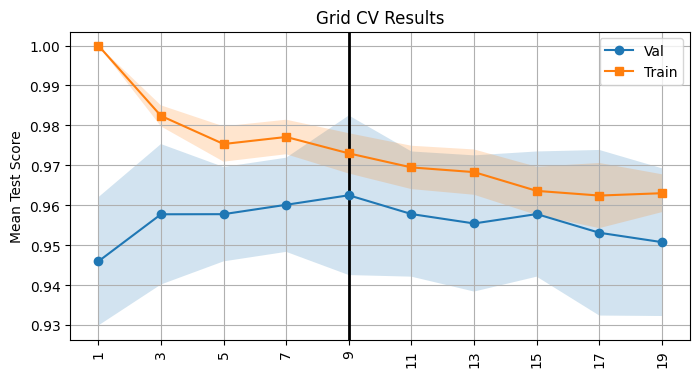

Best parameters: {'clf__n_neighbors': np.int64(9)}
Best Train Score:	0.963
Grid Test SCORE:	0.951


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)  # try random_state

# Define Pipeline
estimators = [('scaler', StandardScaler()), ('clf', KNeighborsClassifier()) ]
pipe = Pipeline(estimators)

# Grid Search Parameters
#params = {'clf__n_neighbors':np.arange(1,11), 'clf__weights':('distance','uniform')}
params = {'clf__n_neighbors':np.arange(1,21, 2)}
#params = {'clf__n_neighbors':np.arange(1,351,30)}
print('Grid Parameters:',params)

grid_clf = GridSearchCV(pipe, param_grid=params, return_train_score=True)
grid_clf.fit(X_train, y_train)
make_grid_plot(grid_clf)

print('Best parameters:', grid_clf.best_params_)
print(f"Best Train Score:\t{grid_clf.best_score_:0.3f}")
print(f"Grid Test SCORE:\t{grid_clf.score(X_test,y_test):0.3f}")

In [13]:
grid_clf.score(X_test, y_test)

0.951048951048951

In [14]:
grid_clf.predict(X_test) # automatically uses the refitted winner!

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0])

In [15]:
res = grid_clf.cv_results_
res.keys() # Wow, look at all of this

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_clf__n_neighbors', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [16]:
# Make a lovely table:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html#sphx-glr-auto-examples-model-selection-plot-grid-search-stats-py
import pandas as pd
results_df = pd.DataFrame(grid_clf.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")

results_df[["params", "rank_test_score", "mean_train_score", "mean_test_score"]].head(10)  # only show best options

,params,rank_test_score,mean_train_score,mean_test_score
kernel,,,,
9,{'clf__n_neighbors': 9},1,0.973005,0.962517
7,{'clf__n_neighbors': 7},2,0.977111,0.960137
11,{'clf__n_neighbors': 11},3,0.969486,0.957811
15,{'clf__n_neighbors': 15},3,0.963616,0.957811
5,{'clf__n_neighbors': 5},5,0.975348,0.957784
3,{'clf__n_neighbors': 3},6,0.982393,0.957756
13,{'clf__n_neighbors': 13},7,0.968313,0.955458
17,{'clf__n_neighbors': 17},8,0.962444,0.953133
19,{'clf__n_neighbors': 19},9,0.963033,0.950780


Now we have all of the pieces we need for a good Machine Learning recipe

Grid Parameters: {'clf__n_neighbors': [5]}


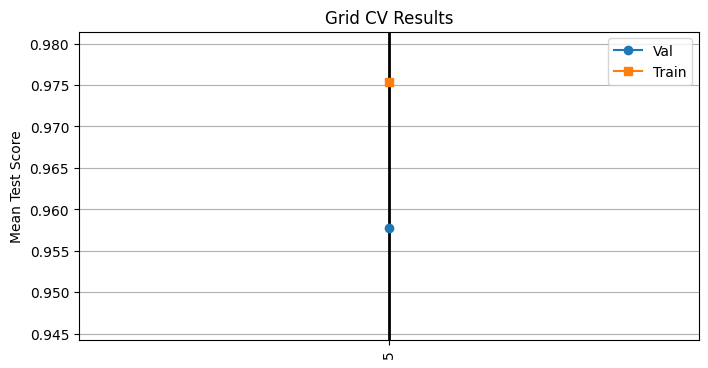

Best parameters: {'clf__n_neighbors': 5}
Best Train Score:	0.958
Grid Test SCORE:	0.951


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)  # try random_state

# Define Pipeline
estimators = [('scaler', StandardScaler()), ('clf', KNeighborsClassifier()) ]
pipe = Pipeline(estimators)

# Grid Search Parameters
#params = {'clf__n_neighbors':np.arange(1,11), 'clf__weights':('distance','uniform')}
params = {'clf__n_neighbors':[5]}
#params = {'clf__n_neighbors':np.arange(1,351,30)}
print('Grid Parameters:',params)

grid_clf = GridSearchCV(pipe, param_grid=params, return_train_score=True)
grid_clf.fit(X_train, y_train)
make_grid_plot(grid_clf)

print('Best parameters:', grid_clf.best_params_)
print(f"Best Train Score:\t{grid_clf.best_score_:0.3f}")
print(f"Grid Test SCORE:\t{grid_clf.score(X_test,y_test):0.3f}")

# The Crusher of Dreams
The plot in which many illusions are shattered.

How much does our answer depend on random_state? A lot!

This is an experimental question.

Grid Parameters: {'clf__n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19])}


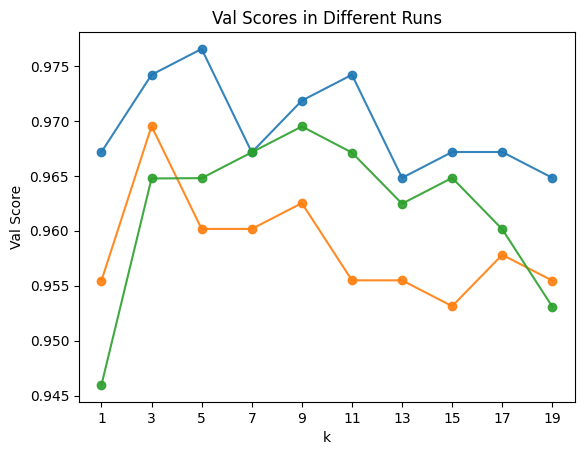

In [18]:
# Visualize 3 different random states

NUM = 3  # takes 43 seconds
KLIST = np.arange(1,21,2)
params = {'clf__n_neighbors':KLIST}
print('Grid Parameters:',params)
grid_clf = GridSearchCV(pipe, param_grid=params, return_train_score=True)

best_counts = np.zeros(len(KLIST)) # save the best fit of each iteration

for i in range(NUM):
  X_train, X_test, y_train, y_test = train_test_split(X, y)
  grid_clf.fit(X_train, y_train)
  res = grid_clf.cv_results_
  best_counts[grid_clf.best_index_]+=1
  plt.plot(res['mean_test_score'],'-o', label='Val', alpha=0.9)
  #plt.plot(res['mean_train_score'],'-o', label='Val', color='tab:orange', alpha=0.05) # makes plot too messy
  plt.xticks(np.arange(len(KLIST)),KLIST)

plt.title('Val Scores in Different Runs')
plt.xlabel('k')
plt.ylabel('Val Score')
plt.show()

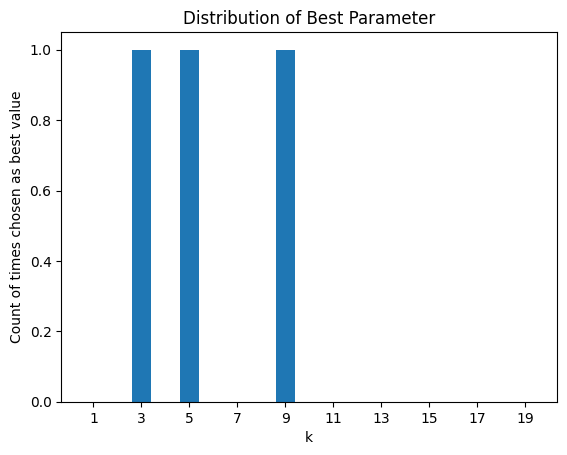

In [19]:
plt.title('Distribution of Best Parameter')
plt.bar(KLIST, best_counts)
plt.xticks(ticks=KLIST,labels=KLIST)
plt.xlabel('k')
plt.ylabel('Count of times chosen as best value')
plt.show()

The main event.  Clean up the plot and run lots of trials.

Grid Parameters: {'clf__n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19])}


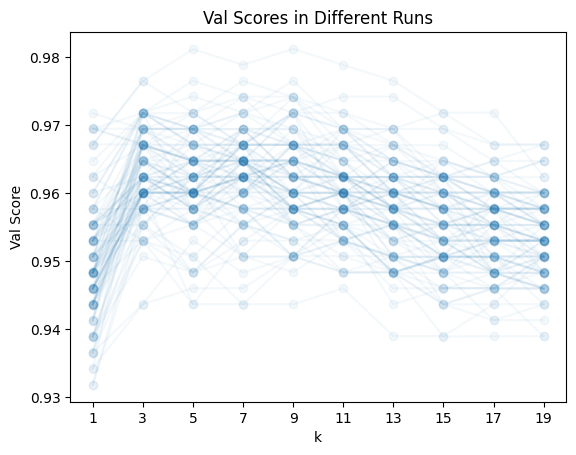

In [20]:
NUM = 100  # 100 takes 43 seconds
#NUM = 50
KLIST = np.arange(1,21,2)
params = {'clf__n_neighbors':KLIST}
print('Grid Parameters:',params)
grid_clf = GridSearchCV(pipe, param_grid=params, return_train_score=True)

best_counts = np.zeros(len(KLIST)) # save the best fit of each iteration

for i in range(NUM):
  X_train, X_test, y_train, y_test = train_test_split(X, y)
  grid_clf.fit(X_train, y_train)
  res = grid_clf.cv_results_
  best_counts[grid_clf.best_index_]+=1
  plt.plot(res['mean_test_score'],'-o', label='Val', color='tab:blue', alpha=0.05)
  #plt.plot(res['mean_train_score'],'-o', label='Val', color='tab:orange', alpha=0.05) # makes plot too messy
  plt.xticks(np.arange(len(KLIST)),KLIST)

plt.title('Val Scores in Different Runs')
plt.xlabel('k')
plt.ylabel('Val Score')
plt.show()
plt.show()

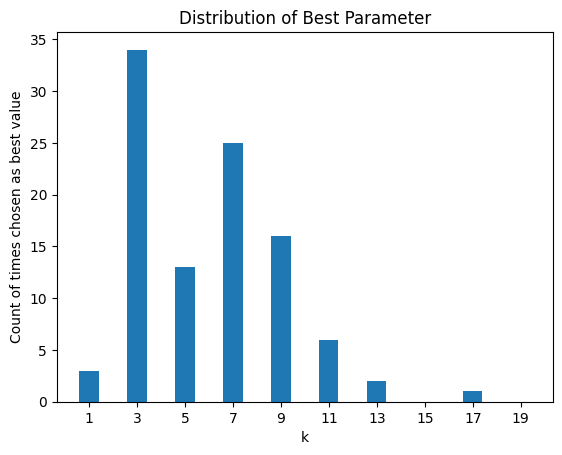

In [21]:
plt.title('Distribution of Best Parameter')
plt.bar(KLIST, best_counts)
plt.xticks(ticks=KLIST,labels=KLIST)
plt.xlabel('k')
plt.ylabel('Count of times chosen as best value')
plt.show()

# Conclusion
* Use a test/train split to evaulate your classifier.  
* Do a CV Grid Search on the training data to tune parameters